This is the main file where we train the CNN network

## Setup

Import TensorFlow and others

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import importlib

import config

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#reload config whenever there are changes
importlib.reload(config)

## Load the training dataset

In [4]:
import pathlib

data_dir = pathlib.Path(r'data\03-training-data')

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

23940


In [6]:
batch_size = 32
img_height = config.img_height
img_width = config.img_width

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23940 files belonging to 6 classes.
Using 19152 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23940 files belonging to 6 classes.
Using 4788 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Class-0-water', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']


## Visualize the data

Here are the first few images from the training dataset:

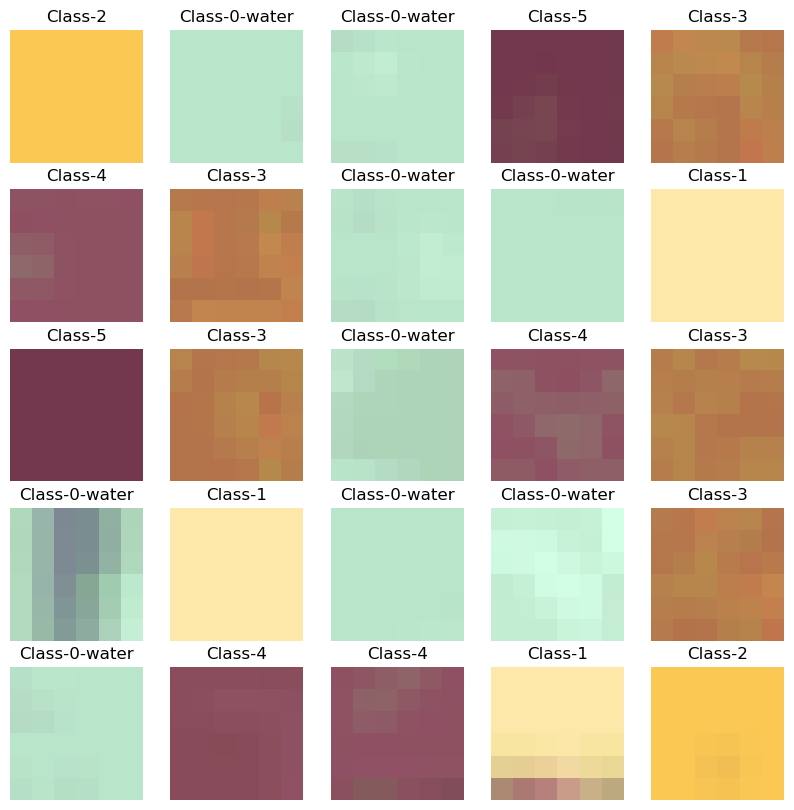

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

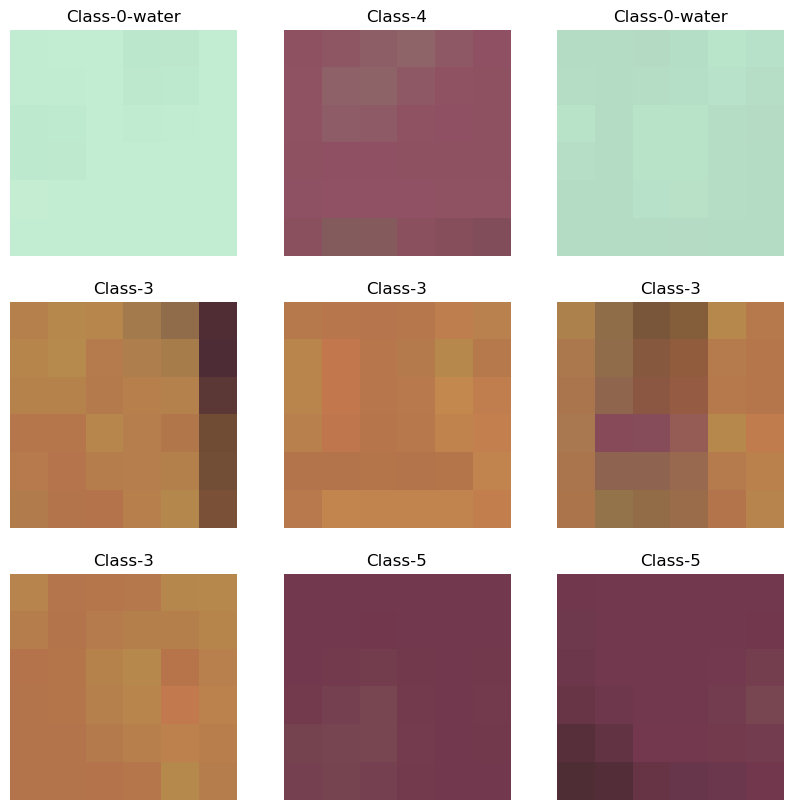

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 6, 6, 3)
(32,)


## Configure the dataset for performance



We autotune, optimise, cache and prefetch. Will help us manage resources better and reduce the risk of the feared overfitting.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values somewhere sub 1.0.


And here's the architecture

In [14]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compile the model

We are going to go with the classic `tf.keras.optimizers.Adam` optimiser and `tf.keras.losses.SparseCategoricalCrossentropy` loss function.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 6, 6, 3)           0         
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 16)          448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32)                0

### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [18]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
599/599 [==============================] - 4s 6ms/step - loss: 0.3013 - accuracy: 0.8938 - val_loss: 0.0408 - val_accuracy: 0.9879
Epoch 2/15
599/599 [==============================] - 2s 3ms/step - loss: 0.0430 - accuracy: 0.9895 - val_loss: 0.0293 - val_accuracy: 0.9919
Epoch 3/15
599/599 [==============================] - 2s 3ms/step - loss: 0.0369 - accuracy: 0.9905 - val_loss: 0.0324 - val_accuracy: 0.9935
Epoch 4/15
599/599 [==============================] - 5s 8ms/step - loss: 0.0371 - accuracy: 0.9912 - val_loss: 0.0192 - val_accuracy: 0.9946
Epoch 5/15
599/599 [==============================] - 4s 6ms/step - loss: 0.0294 - accuracy: 0.9924 - val_loss: 0.0192 - val_accuracy: 0.9944
Epoch 6/15
599/599 [==============================] - 4s 6ms/step - loss: 0.0343 - accuracy: 0.9912 - val_loss: 0.0256 - val_accuracy: 0.9939
Epoch 7/15
599/599 [==============================] - 4s 6ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0165 - val_accuracy: 0.9948
Epoch 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

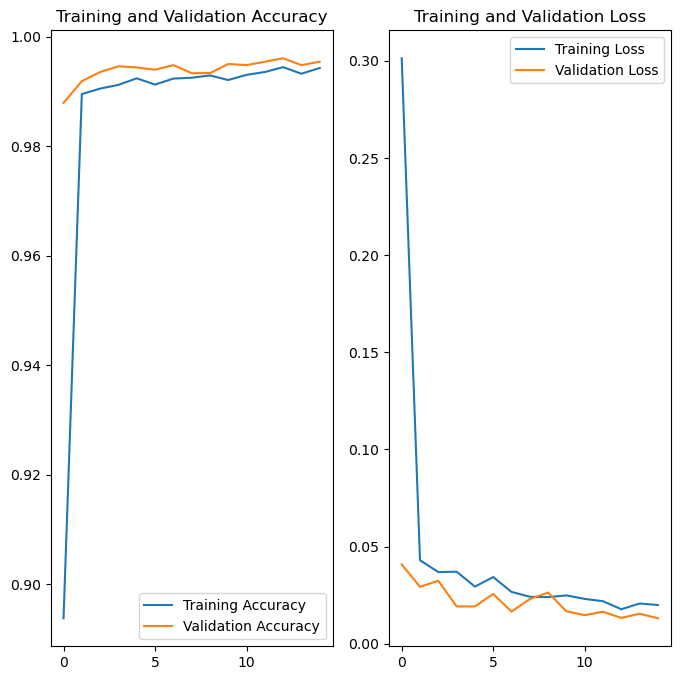

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

THe below model should allow batch processing

In [24]:
import config

# Convert the model with dynamic batch size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.experimental_new_converter = True

# Set the input shape to have dynamic batch size
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_new_quantizer = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

# Ensure input shape is dynamic
def representative_data_gen():
    for _ in range(100):
        yield [np.random.rand(1, img_height, img_width, 3).astype(np.float32)]

converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

tflite_model_path = config.TF_MODEL_FILE_PATH

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmp25pusfuo\assets


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmp25pusfuo\assets
